[View in Colaboratory](https://colab.research.google.com/github/nicewook/datascience_exercise/blob/master/part2_3_4.ipynb)

# 설문조사 응답분석 3, 4
- 강좌링크: https://programmers.co.kr/learn/courses/21
- Part2-3: https://programmers.co.kr/learn/courses/21/lessons/940
- Part2-4: https://programmers.co.kr/learn/courses/21/lessons/941


In [0]:
# 노트북 안에서 그래프 그리는 magic
%matplotlib inline

# import the standard Python Scientific libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress Deprecation and Incorrect Isage Warnings - 워닝 지저분하게 뜨는거 표시하지 않기
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Google Drive와 연결
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools

!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null

!apt-get update -qq 2>&1 > /dev/null

!apt-get -y install -qq google-drive-ocamlfuse fuse

from google.colab import auth

auth.authenticate_user()

from oauth2client.client import GoogleCredentials

creds = GoogleCredentials.get_application_default()

import getpass

!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL

vcode = getpass.getpass()

!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmpvzo0cvga/pubring.gpg' created
gpg: /tmp/tmpvzo0cvga/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
# 폴더를 만들어서 구글 드라이브 연동
!mkdir -p drive 
!google-drive-ocamlfuse drive 

In [7]:
cd drive/kaggle/kaggle-survey-2017/M

/content/drive/kaggle/kaggle-survey-2017


In [8]:
# 판다스로 선다형 객관식 문제에 대한 응답을 가져옴
mcq = pd.read_csv('multipleChoiceResponses.csv', encoding="ISO-8859-1", low_memory=False)
mcq.shape

(16716, 228)

In [9]:
questions = pd.read_csv('schema.csv')  
print(questions.head()) # 질문들이 어떤게 있나 잠시 보자
print(questions.shape)  # 어떤 모양인지 보자

             Column                                           Question Asked
0      GenderSelect     Select your gender identity. - Selected Choice   All
1    GenderFreeForm  Select your gender identity. - A different ide...   All
2           Country          Select the country you currently live in.   All
3               Age                                   What's your age?   All
4  EmploymentStatus             What's your current employment status?   All
(290, 3)


## 여기까지는 기본적으로 구글드라이브 연동
## 아래부터 파트 3,4 시작

In [21]:
# 추천할만한 공부방법
print(mcq['BlogsPodcastsNewslettersSelect'].head())
mcq['BlogsPodcastsNewslettersSelect'] = mcq['BlogsPodcastsNewslettersSelect'].astype('str').apply(lambda x: x.split(','))
print('----------------------------------------')
print(mcq['BlogsPodcastsNewslettersSelect'].head())  # 위에선 콤마로 나눠진 값들이었는데, 여기선 대괄호로 감싸진 리스트가 되었다.

0    [Becoming a Data Scientist Podcast, Data Machi...
1    [Becoming a Data Scientist Podcast, Siraj Rava...
2    [FastML Blog, No Free Hunch Blog, Talking Mach...
3                                     [KDnuggets Blog]
4    [Data Machina Newsletter, Jack's Import AI New...
Name: BlogsPodcastsNewslettersSelect, dtype: object
----------------------------------------
0    [['Becoming a Data Scientist Podcast',  'Data ...
1    [['Becoming a Data Scientist Podcast',  'Siraj...
2    [['FastML Blog',  'No Free Hunch Blog',  'Talk...
3                                 [['KDnuggets Blog']]
4    [['Data Machina Newsletter',  "Jack's Import A...
Name: BlogsPodcastsNewslettersSelect, dtype: object


In [22]:
s = mcq.apply(lambda x : pd.Series(x['BlogsPodcastsNewslettersSelect']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'platform'
s.head()

0    ['Becoming a Data Scientist Podcast'
0               'Data Machina Newsletter'
0              "O'Reilly Data Newsletter"
0          'Partially Derivative Podcast'
0           'R Bloggers Blog Aggregator']
Name: platform, dtype: object

- stack() 은 한줄로 편다고 할까? 한 셀에 여러값이 리스트로 있으면 그걸 하나하나 다른 셀로 옮기는 거다. http://rfriend.tistory.com/276
- reset_index() 는 새로운 인덱스를 준다는 것이고, level=1 은 다중 인덱스중 0번이 아닌1번을 하겠다는 것, drop=True 는 기존 index 를 열로 옮기는게 아니라 그냥 날려버리겠다는 것 https://datascienceschool.net/view-notebook/a49bde24674a46699639c1fa9bb7e213/

In [0]:
# 일단 'nan'은 버리고, 항목별로 취합한다음 상위 20개만 보자
s = s[s != 'nan'].value_counts().head(20)

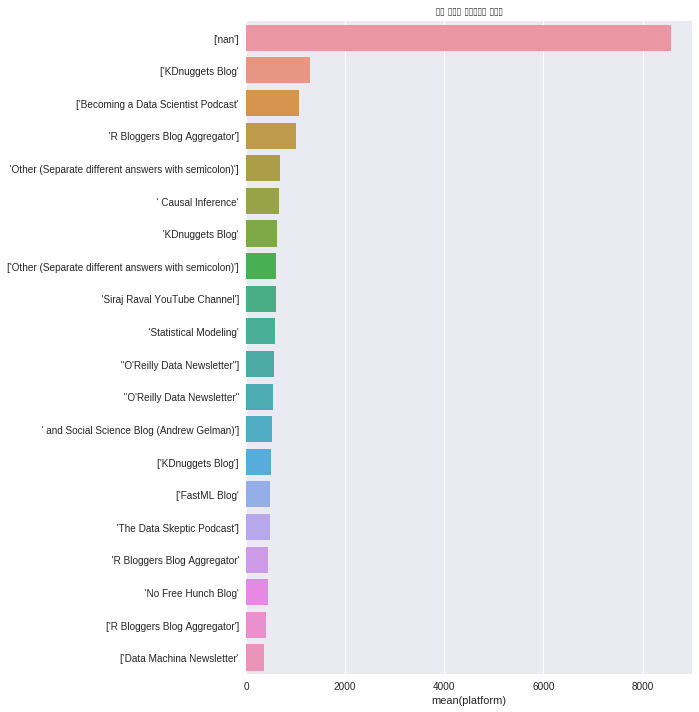

In [24]:
plt.figure(figsize=(8,12))
plt.title("가장 유명한 팟캐스트와 블로그")
sns.barplot(y=s.index, x=s)

In [25]:
s

['nan']                                                  8576
['KDnuggets Blog'                                        1302
['Becoming a Data Scientist Podcast'                     1076
 'R Bloggers Blog Aggregator']                           1018
 'Other (Separate different answers with semicolon)']     688
 ' Causal Inference'                                      662
 'KDnuggets Blog'                                         619
['Other (Separate different answers with semicolon)']     608
 'Siraj Raval YouTube Channel']                           601
 'Statistical Modeling'                                   577
 "O'Reilly Data Newsletter"]                              572
 "O'Reilly Data Newsletter"                               539
 ' and Social Science Blog (Andrew Gelman)']              535
['KDnuggets Blog']                                        498
['FastML Blog'                                            492
 'The Data Skeptic Podcast']                              484
 'R Blog

# 공부하기 좋은 코스는?

In [65]:
#mcq 가 오염되었을 경우 대비해 새로 만들어두자
mcq = pd.read_csv('multipleChoiceResponses.csv', encoding="ISO-8859-1", low_memory=False)
mcq.shape

(16716, 228)

In [66]:
# 일단은 항목을 스트링으로 바꾼 뒤 대답이 여러개인 경우 스플릿해둠
mcq['CoursePlatformSelect'] = mcq['CoursePlatformSelect'].astype('str').apply(lambda x: x.split(','))
mcq['CoursePlatformSelect'].head()

0              [nan]
1              [nan]
2    [Coursera, edX]
3              [nan]
4              [nan]
Name: CoursePlatformSelect, dtype: object

In [67]:
t = mcq.apply(lambda x: pd.Series(x['CoursePlatformSelect']),
 axis=1)
t.head(30)

,0,1,2,3,4
0,nan,NaN,NaN,NaN,NaN
1,nan,NaN,NaN,NaN,NaN
2,Coursera,edX,NaN,NaN,NaN
3,nan,NaN,NaN,NaN,NaN
4,nan,NaN,NaN,NaN,NaN
5,nan,NaN,NaN,NaN,NaN
6,nan,NaN,NaN,NaN,NaN
7,Coursera,NaN,NaN,NaN,NaN
8,nan,NaN,NaN,NaN,NaN
9,nan,NaN,NaN,NaN,NaN


In [0]:
# 위 결과를 보면 최대 5개의 답을 한 것을 알 수 있다. 
# 이것을 stack 으로 하면 1개의 열이 될거다
t = t.stack()


In [69]:
# 그러면 인덱스가 2레벨이 된게 보인다. 이걸 reset_index 해주고 기존 인덱스는 버린다 (drop=True)
t.reset_index(level=1, drop=True)
t.head(20)

0   0         nan
1   0         nan
2   0    Coursera
    1         edX
3   0         nan
4   0         nan
5   0         nan
6   0         nan
7   0    Coursera
8   0         nan
9   0         nan
10  0    Coursera
11  0         nan
12  0    Coursera
    1    DataCamp
    2         edX
13  0         nan
14  0         nan
15  0         nan
16  0         nan
dtype: object

In [70]:
t.name = 'courses'
t.head(20)

0   0         nan
1   0         nan
2   0    Coursera
    1         edX
3   0         nan
4   0         nan
5   0         nan
6   0         nan
7   0    Coursera
8   0         nan
9   0         nan
10  0    Coursera
11  0         nan
12  0    Coursera
    1    DataCamp
    2         edX
13  0         nan
14  0         nan
15  0         nan
16  0         nan
Name: courses, dtype: object

In [0]:
# nan 는 버리고 그루핑해보자
t = t[t != 'nan'].value_counts()

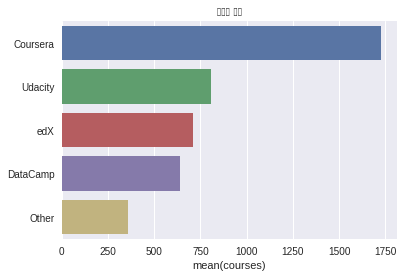

In [72]:
plt.title("유명한 코스")  # 맷플롯립에서 한글은 안되고 있음.
sns.barplot(y=t.index, x=t)

In [78]:
# 직무에서 가장 중요한 스킬은? Job 관련 컬럼들을 뽑아보자
job_features = [
 x for x in mcq.columns if x.find(
 'JobSkillImportance') != -1
 and x.find('JobSkillImportanceOther') == -1]

job_features

['JobSkillImportanceBigData',
 'JobSkillImportanceDegree',
 'JobSkillImportanceStats',
 'JobSkillImportanceEnterpriseTools',
 'JobSkillImportancePython',
 'JobSkillImportanceR',
 'JobSkillImportanceSQL',
 'JobSkillImportanceKaggleRanking',
 'JobSkillImportanceMOOC',
 'JobSkillImportanceVisualizations']

In [79]:
# 딕셔너리를 만들고, 각각의 컬럼에서 그루핑하여 비율을 적어둔다
jdf = {}
for feature in job_features:
 a = mcq[feature].value_counts()
 a = a/a.sum()
 jdf[feature[len('JobSkillImportance'):]] = a

jdf

{'BigData': Nice to have    0.574065
 Necessary       0.379929
 Unnecessary     0.046006
 Name: JobSkillImportanceBigData, dtype: float64,
 'Degree': Nice to have    0.598107
 Necessary       0.279867
 Unnecessary     0.122026
 Name: JobSkillImportanceDegree, dtype: float64,
 'EnterpriseTools': Nice to have    0.564970
 Unnecessary     0.290200
 Necessary       0.144829
 Name: JobSkillImportanceEnterpriseTools, dtype: float64,
 'KaggleRanking': Nice to have    0.677261
 Unnecessary     0.203876
 Necessary       0.118863
 Name: JobSkillImportanceKaggleRanking, dtype: float64,
 'MOOC': Nice to have    0.606994
 Unnecessary     0.285752
 Necessary       0.107255
 Name: JobSkillImportanceMOOC, dtype: float64,
 'Python': Necessary       0.645994
 Nice to have    0.327214
 Unnecessary     0.026792
 Name: JobSkillImportancePython, dtype: float64,
 'R': Nice to have    0.513945
 Necessary       0.414807
 Unnecessary     0.071247
 Name: JobSkillImportanceR, dtype: float64,
 'SQL': Nice to have 

In [80]:
jdf = pd.DataFrame(jdf).transpose()
jdf

,Necessary,Nice to have,Unnecessary
BigData,0.379929,0.574065,0.046006
Degree,0.279867,0.598107,0.122026
EnterpriseTools,0.144829,0.564970,0.290200
KaggleRanking,0.118863,0.677261,0.203876
MOOC,0.107255,0.606994,0.285752
Python,0.645994,0.327214,0.026792
R,0.414807,0.513945,0.071247
SQL,0.434224,0.491778,0.073998
Stats,0.513889,0.457576,0.028535
Visualizations,0.455392,0.490820,0.053788


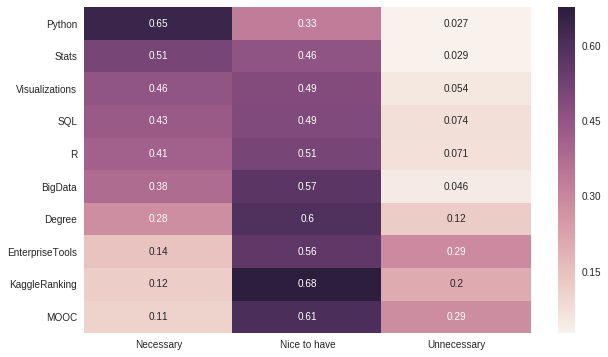

In [81]:
# 히트맵을 써보자
plt.figure(figsize=(10,6))
sns.heatmap(jdf.sort_values("Necessary", ascending=False), annot=True) # annot 는 각 셀의 값 적어줄지 여부임

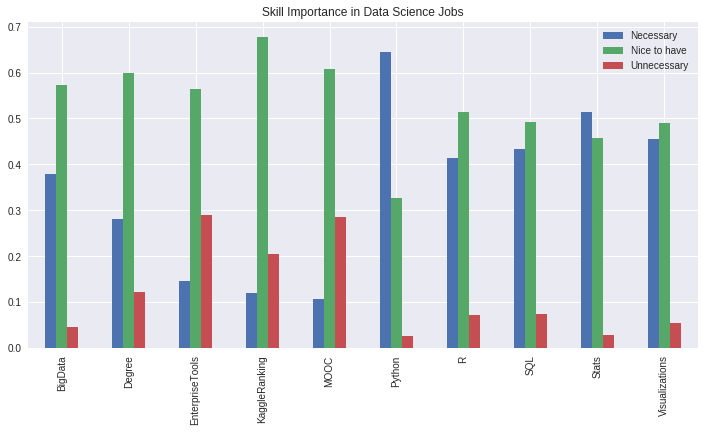

In [82]:
jdf.plot(kind='bar', figsize=(12,6),
 title="Skill Importance in Data Science Jobs")

# 데이터 과학자의 평균급여

In [0]:
#mcq 가 오염되었을 경우 대비해 새로 만들어두자
mcq = pd.read_csv('multipleChoiceResponses.csv', encoding="ISO-8859-1", low_memory=False)

In [98]:
mcq[mcq['CompensationAmount'].notnull()].shape

(5224, 228)

In [99]:
mcq['CompensationAmount'].head()

0        NaN
1        NaN
2        NaN
3    250,000
4        NaN
Name: CompensationAmount, dtype: object

In [101]:
mcq['CompensationAmount'] = mcq[ 'CompensationAmount'].str.replace(',','') # 콤마는 없애자. 급여에 콤마로 적은 애들이 있음
mcq['CompensationAmount'] = mcq[ 'CompensationAmount'].str.replace('-','') # -도 없애자 

mcq['CompensationAmount'].head()

0       NaN
1       NaN
2       NaN
3    250000
4       NaN
Name: CompensationAmount, dtype: object

In [102]:
# 환율계산을 위한 정보 가져오기
rates = pd.read_csv('conversionRates.csv')
rates.drop('Unnamed: 0',axis=1,inplace=True)

salary = mcq[ ['CompensationAmount','CompensationCurrency', 'GenderSelect', 'Country', 'CurrentJobTitleSelect']].dropna()
salary = salary.merge(rates,left_on='CompensationCurrency', right_on='originCountry', how='left')
salary['Salary'] = pd.to_numeric( salary['CompensationAmount']) * salary['exchangeRate']
salary.head()

,CompensationAmount,CompensationCurrency,GenderSelect,Country,CurrentJobTitleSelect,originCountry,exchangeRate,Salary
0,250000,USD,Male,United States,Operations Research Practitioner,USD,1.000000,250000.0
1,80000,AUD,Female,Australia,Business Analyst,AUD,0.802310,64184.8
2,1200000,RUB,Male,Russia,Software Developer/Software Engineer,RUB,0.017402,20882.4
3,95000,INR,Male,India,Data Scientist,INR,0.015620,1483.9
4,1100000,TWD,Male,Taiwan,Software Developer/Software Engineer,TWD,0.033304,36634.4


Text(0.5,1,'Highest Salary Paying Countries')

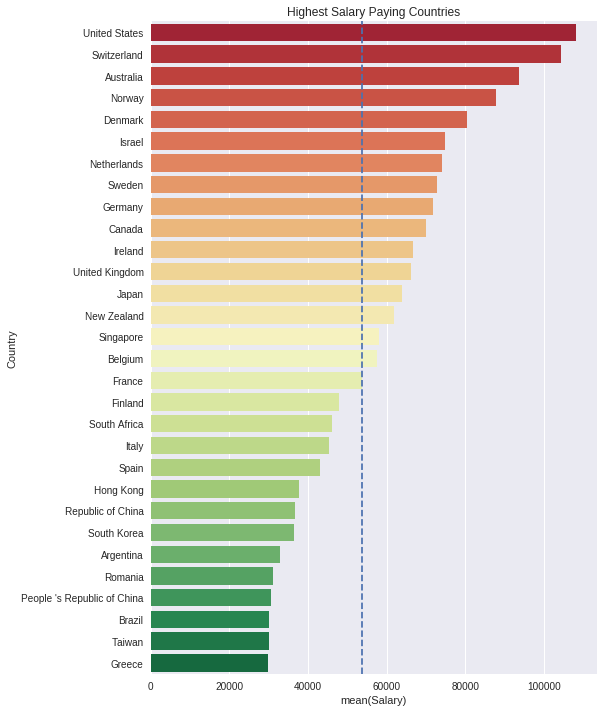

In [103]:
plt.subplots(figsize=(8,12))

sal_coun = salary.groupby('Country')['Salary'].median().sort_values( ascending=False)[:30].to_frame()

sns.barplot('Salary', sal_coun.index, data = sal_coun, palette='RdYlGn')

plt.axvline(salary['Salary'].median(), linestyle='dashed')
plt.title('Highest Salary Paying Countries')

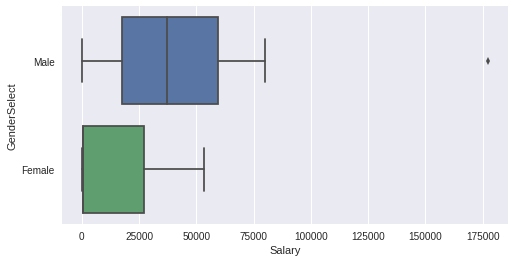

In [105]:
salary_korea = salary.loc[(salary['Country']=='South Korea')]
plt.subplots(figsize=(8,4))
sns.boxplot(y='GenderSelect',x='Salary',data=salary_korea)

In [106]:
salary_korea.shape

(26, 8)

In [107]:
salary_korea[salary_korea['GenderSelect'] == 'Female']

,CompensationAmount,CompensationCurrency,GenderSelect,Country,CurrentJobTitleSelect,originCountry,exchangeRate,Salary
479,30000,KRW,Female,South Korea,Data Analyst,KRW,0.000886,26.58
2903,800000,KRW,Female,South Korea,Researcher,KRW,0.000886,708.80
4063,60000000,KRW,Female,South Korea,Researcher,KRW,0.000886,53160.00


In [108]:
salary_korea_male = salary_korea[
 salary_korea['GenderSelect']== 'Male']
salary_korea_male['Salary'].describe()

count        23.000000
mean      43540.617217
std       37800.608484
min           0.886000
25%       17500.000000
50%       37212.000000
75%       59238.000000
max      177200.000000
Name: Salary, dtype: float64

In [109]:
salary_korea_male

,CompensationAmount,CompensationCurrency,GenderSelect,Country,CurrentJobTitleSelect,originCountry,exchangeRate,Salary
85,40000000,KRW,Male,South Korea,Business Analyst,KRW,0.000886,35440.000
147,80000,USD,Male,South Korea,Researcher,USD,1.000000,80000.000
314,60000,USD,Male,South Korea,Business Analyst,USD,1.000000,60000.000
333,60000000,KRW,Male,South Korea,Researcher,KRW,0.000886,53160.000
562,50000000,KRW,Male,South Korea,Researcher,KRW,0.000886,44300.000
769,42000000,KRW,Male,South Korea,Software Developer/Software Engineer,KRW,0.000886,37212.000
799,1000,KRW,Male,South Korea,Machine Learning Engineer,KRW,0.000886,0.886
1060,75000000,KRW,Male,South Korea,Scientist/Researcher,KRW,0.000886,66450.000
1360,30000000,KRW,Male,South Korea,Statistician,KRW,0.000886,26580.000
1568,90000,SGD,Male,South Korea,Computer Scientist,SGD,0.742589,66833.010


# 개인 프로젝트, 학습용 데이터를 얻는 방법


In [0]:
mcq['PublicDatasetsSelect'] = mcq[
 'PublicDatasetsSelect'].astype('str').apply(
 lambda x: x.split(',')
 )

In [0]:
q = mcq.apply(
 lambda x: pd.Series(x['PublicDatasetsSelect']),
 axis=1).stack().reset_index(level=1, drop=True)

q.name = 'courses'

In [112]:
q.head()

0    Dataset aggregator/platform (i.e. Socrata/Kagg...
0        University/Non-profit research group websites
0                                                Other
1    Dataset aggregator/platform (i.e. Socrata/Kagg...
2    Dataset aggregator/platform (i.e. Socrata/Kagg...
Name: courses, dtype: object

In [0]:
q = q[q != 'nan'].value_counts()

In [114]:
pd.DataFrame(q)

,courses
Dataset aggregator/platform (i.e. Socrata/Kaggle Datasets/data.world/etc.),6843
Google Search,3600
University/Non-profit research group websites,2873
I collect my own data (e.g. web-scraping),2560
GitHub,2400
Government website,2079
Other,399


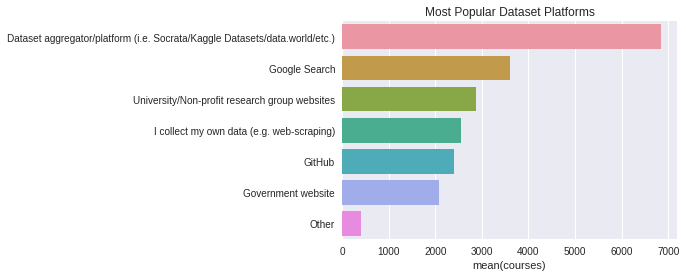

In [115]:
plt.title("Most Popular Dataset Platforms")
sns.barplot(y=q.index, x=q)

In [118]:
# 주관식 응답을 읽어온다.
ff = pd.read_csv('freeformResponses.csv', encoding="ISO-8859-1", low_memory=False)
ff.shape

(16716, 62)

In [119]:
ppcff = ff[
 'PersonalProjectsChallengeFreeForm'].value_counts().head(15)
ppcff.name = '응답 수'
pd.DataFrame(ppcff)

,응답 수
None,23
Cleaning the data,20
Cleaning,20
Dirty data,16
Data Cleaning,14
none,13
dirty data,10
Data cleaning,10
Size,9
-,9
